<a href="https://colab.research.google.com/github/josvalen/practicetemp/blob/main/Zoobot_Finetune_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Downloads a pretrained checkpoint
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning



---



*Retraining will be quite slow unless you use a GPU. Use the top
toolbar: Runtime- > Change Runtime -> GPU*

---

## Install Zoobot

In [2]:
!git clone https://github.com/mwalmsley/zoobot.git # places the cloned repo into zoobot_dir

# there's an identical notebook I use for testing the pre-release versions of zoobot and galaxy-datasets here, if useful
# https://colab.research.google.com/drive/1A_-M3Sz5maQmyfW2A7rEu-g_Zi0RMGz5?usp=sharing

Cloning into 'zoobot'...
remote: Enumerating objects: 8365, done.
remote: Counting objects: 100% (2353/2353), done.
remote: Compressing objects: 100% (782/782), done.
remote: Total 8365 (delta 1618), reused 2275 (delta 1561), pack-reused 6012
Receiving objects: 100% (8365/8365), 334.18 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (5209/5209), done.


In [1]:
!pip install -e /content/zoobot[pytorch_colab]

Obtaining file:///content/zoobot
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for zoobot (pyproject.toml) ... done
  Created wheel for zoobot: filename=zoobot-1.0.4-0.editable-py3-none-any.whl size=19902 sha256=6189b7e7e9654e9a92aec1cbed7086f4b4962a33c11323317e373ea5e725e0fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-isuydlj1/wheels/b8/32/e8/b630fb8c4ddc2b98bfdc0c6454a7b0264bd72d5b00449d0d0f
Successfully built zoobot
  Attempting uninstall: zoobot
    Found existing installation: zoobot 1.0.4
    Uninstalling zoobot-1.0.4:
      Successfully uninstalled zoobot-1.0.4




If you will get the error below later:
> AttributeError: module 'pkg_resources._vendor.packaging' has no attribute 'requirements'

then restart the runtime and run it again - press the button just above.

In [2]:
# google colab needs this hack to make git-cloned packaged importable
# it's not needed locally
import os
import sys
zoobot_dir = '/content/zoobot'
os.chdir(zoobot_dir)
sys.path.append(zoobot_dir)
!git pull  # just to make sure we're up to date

Already up to date.


Now we're set up and can start using Zoobot.

## Download Pretrained Checkpoint

In [3]:


# make a directory to place the checkpoint
# this could be anywhere, but Zoobot has this folder already
checkpoint_dir = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch')  # Can place your checkpoint anywhere,

# if not os.path.isdir(checkpoint_dir):
#   os.makedirs(checkpoint_dir)

Download the pretrained model checkpoint from Dropbox.

The pretrained models are described and linked from the [Data Notes](https://zoobot.readthedocs.io/en/latest/data_notes.html) docs.

Outside Colab, you can just download them with a browser.
On Colab, we don't have a file browser, so we have will download them with this one-liner.

In [4]:
!wget --no-check-certificate 'https://dl.dropboxusercontent.com/s/7ixwo59imjfz4ay/effnetb0_greyscale_224px.ckpt?dl=0' -O $checkpoint_dir/checkpoint.ckpt

--2023-08-01 18:23:10--  https://dl.dropboxusercontent.com/s/7ixwo59imjfz4ay/effnetb0_greyscale_224px.ckpt?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6022:15::a27d:420f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17384753 (17M) [application/octet-stream]
Saving to: ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’

/content/zoobot/dat 100%[===================>]  16.58M  10.5MB/s    in 1.6s    

2023-08-01 18:23:13 (10.5 MB/s) - ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’ saved [17384753/17384753]



## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

Here I'm using galaxy-datasets to download some premade data - check it out for examples.

In [5]:
# galaxy-datasets is a dependency of Zoobot.
# It has code handling downloading and loading data.
from galaxy_datasets import demo_rings

In [6]:
data_dir = os.path.join(zoobot_dir, 'data/demo_rings')

In [7]:
train_catalog, label_cols = demo_rings(root=data_dir, download=True, train=True)
test_catalog, _ = demo_rings(root=data_dir, download=True, train=False)

100%|██████████| 30797/30797 [00:00<00:00, 16076164.32it/s]


100%|██████████| 10802/10802 [00:00<00:00, 26188943.24it/s]


100%|██████████| 43446358/43446358 [00:08<00:00, 4931475.81it/s]


Extracting /content/zoobot/data/demo_rings/demo_rings_images.tar.gz to /content/zoobot/data/demo_rings
Using downloaded and verified file: /content/zoobot/data/demo_rings/demo_rings_train_catalog.parquet
Using downloaded and verified file: /content/zoobot/data/demo_rings/demo_rings_test_catalog.parquet
Using downloaded and verified file: /content/zoobot/data/demo_rings/demo_rings_images.tar.gz
Extracting /content/zoobot/data/demo_rings/demo_rings_images.tar.gz to /content/zoobot/data/demo_rings


In [8]:
train_catalog.head()

,id_str,ring_fraction,subfolder,filename,ring,file_loc
0,487483_3522,0.714286,487483,487483_3522.jpg,True,/content/zoobot/data/demo_rings/images/487483/...
1,287521_2026,0.666667,287521,287521_2026.jpg,True,/content/zoobot/data/demo_rings/images/287521/...
2,519986_112,0.583333,519986,519986_112.jpg,True,/content/zoobot/data/demo_rings/images/519986/...
3,362959_3369,0.800000,362959,362959_3369.jpg,True,/content/zoobot/data/demo_rings/images/362959/...
4,426137_3385,0.700000,426137,426137_3385.jpg,True,/content/zoobot/data/demo_rings/images/426137/...


Wondering about "label_cols"?

This is a list of catalog columns which should be used as labels

Here,`label_cols = ['ring']`



In [9]:
label_cols

['ring']

For binary classification, the label column should have binary (0 or 1) labels for your classes.

To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine.


## Configure Finetuning

In [10]:
import pandas as pd

from zoobot.pytorch.training import finetune
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [11]:
# TODO you can update these paths to suit own data
checkpoint_loc = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch/checkpoint.ckpt')  # downloaded above
save_dir = os.path.join(zoobot_dir, 'results/pytorch/finetune/finetune_binary_classification')

In [12]:
label_col = 'ring'  # name of column in catalog with binary (0 or 1) labels for your classes
label_cols = [label_col]  # To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine.

In [13]:
datamodule = GalaxyDataModule(
  label_cols=label_cols,
  catalog=train_catalog,
  batch_size=32,
  resize_after_crop=224,  # the size of the images input to the model
  num_workers=2  # sets the parallelism for loading data. 2 works well on colab.
)

## Check Images Load

Optional - check that all images load correctly.

Worth checking once, and especially if you get "InvalidArgumentError" when running the model below.

In [14]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

# Now the Actual Finetuning

In [15]:
model = finetune.FinetuneableZoobotClassifier(
  checkpoint_loc=checkpoint_loc,
  num_classes=2,
  n_layers=2  # only updating the head weights. Set 0 for only output layer. Set e.g. 1, 2 to finetune deeper.
)
# don't worry about any "automatically upgraded" INFO message below

In [16]:
trainer = finetune.get_trainer(save_dir, accelerator='auto', devices='auto', max_epochs=130)
trainer.fit(model, datamodule)
# should reach about 80% accuracy, loss of about 0.4

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | EfficientNet     | 4.0 M 
1 | train_loss_metric | MeanMetric       | 0     
2 | val_loss_metric   | MeanMetric       | 0     
3 | test_loss_metric  | MeanMetric       | 0     
4 | head              | LinearClassifier | 2.6 K 
5 | train_acc         | BinaryAccuracy   | 0     
6 | val_acc           | BinaryAccuracy   | 0     
7 | test_acc          | BinaryAccuracy   | 0     
---------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 18: 'finetuning/val_loss' reached 0.68375 (best 0.68375), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/0.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 36: 'finetuning/val_loss' reached 0.67694 (best 0.67694), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 54: 'finetuning/val_loss' reached 0.66912 (best 0.66912), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 72: 'finetuning/val_loss' reached 0.66225 (best 0.66225), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 90: 'finetuning/val_loss' reached 0.65496 (best 0.65496), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 108: 'finetuning/val_loss' reached 0.64894 (best 0.64894), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 126: 'finetuning/val_loss' reached 0.64285 (best 0.64285), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 144: 'finetuning/val_loss' reached 0.63947 (best 0.63947), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/7.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 162: 'finetuning/val_loss' reached 0.63207 (best 0.63207), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/8.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 180: 'finetuning/val_loss' reached 0.62792 (best 0.62792), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/9.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 198: 'finetuning/val_loss' reached 0.62137 (best 0.62137), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 216: 'finetuning/val_loss' reached 0.61625 (best 0.61625), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/11.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 234: 'finetuning/val_loss' reached 0.61280 (best 0.61280), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/12.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 252: 'finetuning/val_loss' reached 0.60637 (best 0.60637), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/13.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 270: 'finetuning/val_loss' reached 0.60235 (best 0.60235), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/14.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 288: 'finetuning/val_loss' reached 0.59937 (best 0.59937), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/15.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 306: 'finetuning/val_loss' reached 0.59327 (best 0.59327), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/16.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 324: 'finetuning/val_loss' reached 0.59211 (best 0.59211), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/17.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 342: 'finetuning/val_loss' reached 0.58547 (best 0.58547), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/18.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 360: 'finetuning/val_loss' reached 0.58251 (best 0.58251), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/19.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 378: 'finetuning/val_loss' reached 0.57754 (best 0.57754), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/20.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 396: 'finetuning/val_loss' reached 0.57261 (best 0.57261), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/21.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 414: 'finetuning/val_loss' reached 0.57070 (best 0.57070), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/22.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 432: 'finetuning/val_loss' reached 0.56695 (best 0.56695), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/23.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 450: 'finetuning/val_loss' reached 0.55868 (best 0.55868), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/24.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 468: 'finetuning/val_loss' reached 0.55751 (best 0.55751), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 486: 'finetuning/val_loss' reached 0.55007 (best 0.55007), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/26.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 504: 'finetuning/val_loss' reached 0.55002 (best 0.55002), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/27.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 522: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 540: 'finetuning/val_loss' reached 0.54786 (best 0.54786), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/29.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 558: 'finetuning/val_loss' reached 0.53834 (best 0.53834), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/30.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 576: 'finetuning/val_loss' reached 0.53689 (best 0.53689), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/31.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 594: 'finetuning/val_loss' reached 0.53237 (best 0.53237), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/32.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 612: 'finetuning/val_loss' reached 0.52886 (best 0.52886), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/33.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 630: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 648: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 666: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 684: 'finetuning/val_loss' reached 0.52055 (best 0.52055), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/37.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 702: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 720: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 738: 'finetuning/val_loss' reached 0.51946 (best 0.51946), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/40.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 756: 'finetuning/val_loss' reached 0.50593 (best 0.50593), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/41.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 774: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 792: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 810: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 828: 'finetuning/val_loss' reached 0.49996 (best 0.49996), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 846: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 864: 'finetuning/val_loss' reached 0.49350 (best 0.49350), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/47.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 882: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 900: 'finetuning/val_loss' reached 0.48872 (best 0.48872), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/49.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 918: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 936: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 954: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 972: 'finetuning/val_loss' reached 0.48442 (best 0.48442), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/53.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 990: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 1008: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 1026: 'finetuning/val_loss' reached 0.48131 (best 0.48131), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/56.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 1044: 'finetuning/val_loss' reached 0.47320 (best 0.47320), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/57.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 1062: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 1080: 'finetuning/val_loss' reached 0.46800 (best 0.46800), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/59.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 1098: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 1116: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 1134: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 1152: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 1170: 'finetuning/val_loss' reached 0.46484 (best 0.46484), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/64.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 1188: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 1206: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 1224: 'finetuning/val_loss' reached 0.46155 (best 0.46155), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/67.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 1242: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 1260: 'finetuning/val_loss' reached 0.45536 (best 0.45536), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/69.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 1278: 'finetuning/val_loss' reached 0.45335 (best 0.45335), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/70.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 1296: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 1314: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 1332: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 1350: 'finetuning/val_loss' reached 0.44369 (best 0.44369), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/74.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 1368: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 1386: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 1404: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 1422: 'finetuning/val_loss' reached 0.44215 (best 0.44215), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/78.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 1440: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 1458: 'finetuning/val_loss' reached 0.43668 (best 0.43668), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/80.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 1476: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 1494: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 1512: 'finetuning/val_loss' reached 0.43620 (best 0.43620), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/83.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 1530: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 1548: 'finetuning/val_loss' reached 0.43455 (best 0.43455), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/85.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 1566: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 1584: 'finetuning/val_loss' reached 0.43451 (best 0.43451), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/87.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 1602: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 1620: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 1638: 'finetuning/val_loss' reached 0.43119 (best 0.43119), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/90.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 1656: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 1674: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 1692: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 1710: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 1728: 'finetuning/val_loss' reached 0.43039 (best 0.43039), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/95.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 1746: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 1764: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 1782: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 1800: 'finetuning/val_loss' reached 0.41760 (best 0.41760), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/99.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 1818: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 1836: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 1854: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 1872: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 1890: 'finetuning/val_loss' reached 0.40996 (best 0.40996), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/104.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 1908: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 1926: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 1944: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 1962: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 1980: 'finetuning/val_loss' reached 0.40720 (best 0.40720), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/109.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 1998: 'finetuning/val_loss' reached 0.39934 (best 0.39934), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/110.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 111, global step 2016: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 112, global step 2034: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 113, global step 2052: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 114, global step 2070: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 115, global step 2088: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 116, global step 2106: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 117, global step 2124: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 118, global step 2142: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 119, global step 2160: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 120, global step 2178: 'finetuning/val_loss' reached 0.39393 (best 0.39393), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/120.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 121, global step 2196: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 122, global step 2214: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 123, global step 2232: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 124, global step 2250: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 125, global step 2268: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 126, global step 2286: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 127, global step 2304: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 128, global step 2322: 'finetuning/val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 129, global step 2340: 'finetuning/val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=130` reached.


In [17]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = finetune.FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

In [18]:
from zoobot.pytorch.predictions import predict_on_catalog

predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  label_cols=label_cols,
  save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2}
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Let's quickly check if they're any good:

In [19]:
predictions = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions.csv'))
predictions.head()

,id_str,ring_pred
0,453526_3245,0.772819
1,127202_5277,0.550692
2,469597_327,0.282232
3,433105_1762,0.097408
4,52497_3109,0.799095


In [20]:

predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'ring']])
predictions.head()

,id_str,ring_pred,file_loc,ring
0,453526_3245,0.772819,/content/zoobot/data/demo_rings/images/453526/...,True
1,127202_5277,0.550692,/content/zoobot/data/demo_rings/images/127202/...,True
2,469597_327,0.282232,/content/zoobot/data/demo_rings/images/469597/...,False
3,433105_1762,0.097408,/content/zoobot/data/demo_rings/images/433105/...,False
4,52497_3109,0.799095,/content/zoobot/data/demo_rings/images/52497/5...,True


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_rings(df):
  # little utility function to visualise galaxies and our ring labels/predictions

  fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
  for n in range(5):
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['ring_pred']) == galaxy['ring']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 50, 'Pred: {:.2f}'.format(galaxy['ring_pred']), color=color)
    axes[n].text(20, 90, 'Label: {}'.format(galaxy['ring']), color=color)

    axes[n].axis('off')

45     228384_1060
50     496393_4172
63     333402_4852
144    385518_4205
47      208040_773
          ...     
133    366409_2418
142    327030_1714
57     348565_3693
152       341089_9
77     326911_5263
Name: id_str, Length: 200, dtype: object


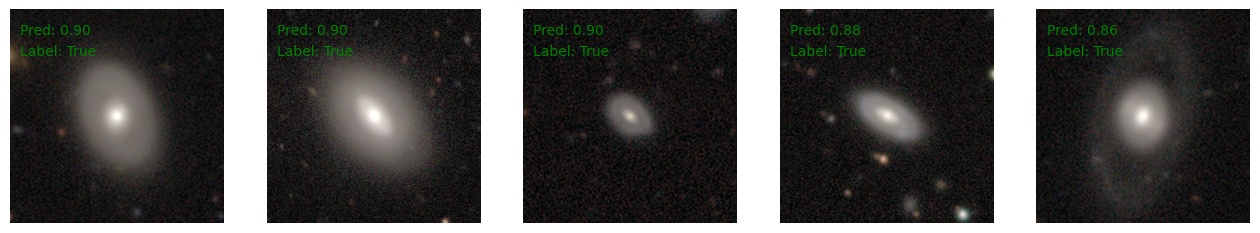

In [22]:
top_5_predictions = predictions.sort_values('ring_pred', ascending=False)
show_rings(top_5_predictions)
print(top_5_predictions['id_str'])

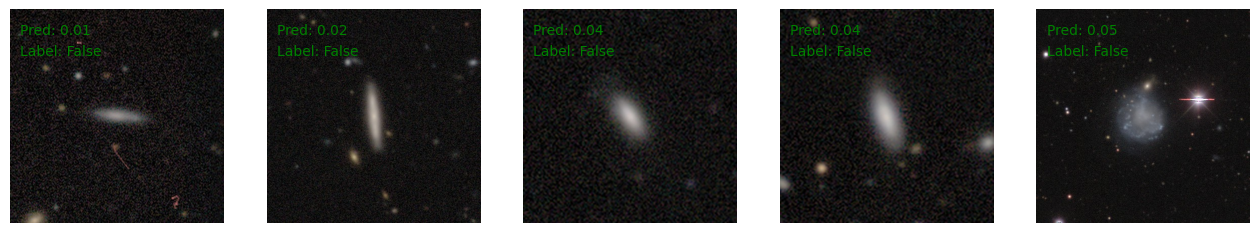

In [23]:
bottom_5_predictions = predictions.sort_values('ring_pred', ascending=True)
show_rings(bottom_5_predictions)

17     404690_1539
144    385518_4205
20     418107_3716
157    493765_2349
90     454707_4037
Name: id_str, dtype: object


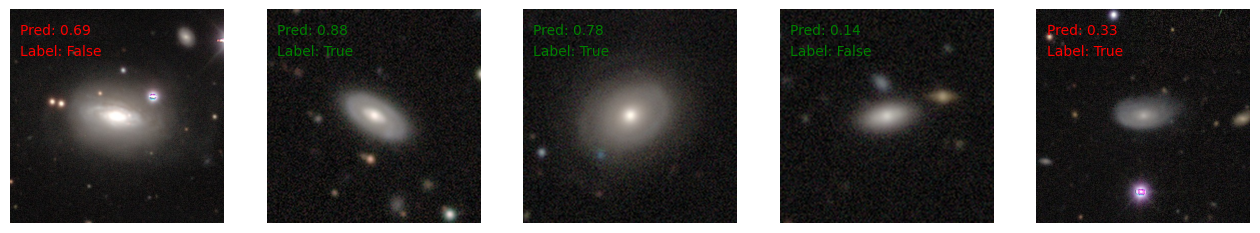

In [24]:
random_predictions = predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions)

Pretty good given only a couple of hundred examples for each class.


In [25]:
train_catalog[label_col].value_counts()

False    427
True     373
Name: ring, dtype: int64